In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Thu Jan 25 03:35:15 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   35C    P0    44W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.0
hp.M = hp.n_prior_embeddings
hp.z_activation = F.tanh

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_nupdate/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 7580
-rw-rw-r-- 1 scpark scpark  279710  1월 25 03:35 events.out.tfevents.1706121119.GPUSVR11
-rw-rw-r-- 1 scpark scpark     222  1월 25 03:33 events.out.tfevents.1706121083.GPUSVR11
-rw-rw-r-- 1 scpark scpark 7471539  1월 25 03:32 save_0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

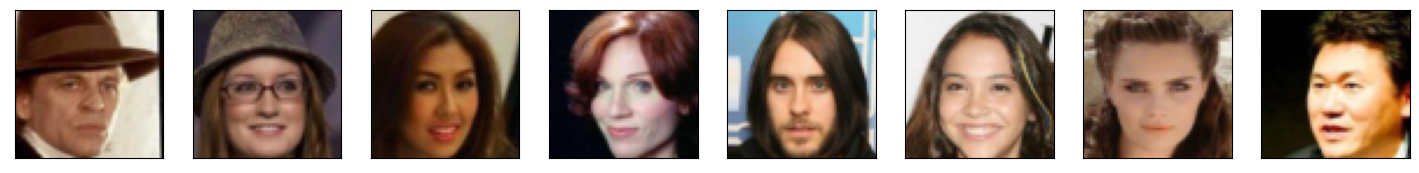

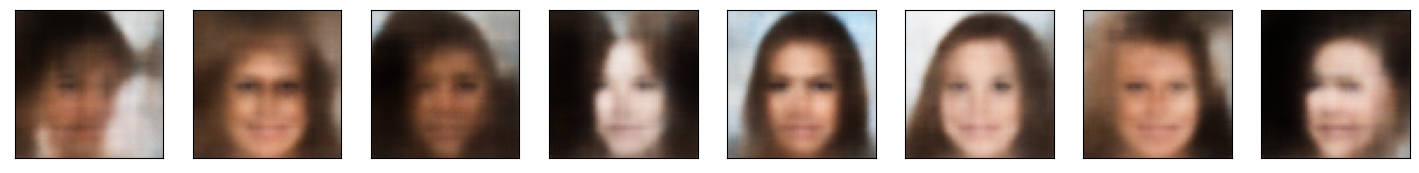

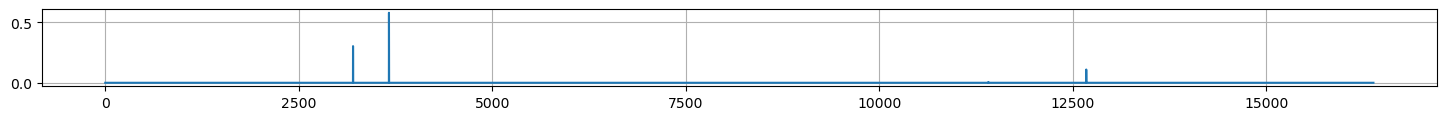

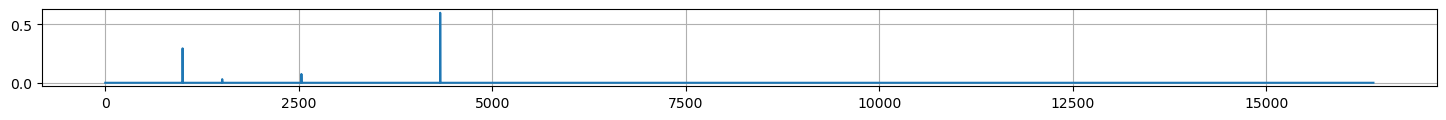

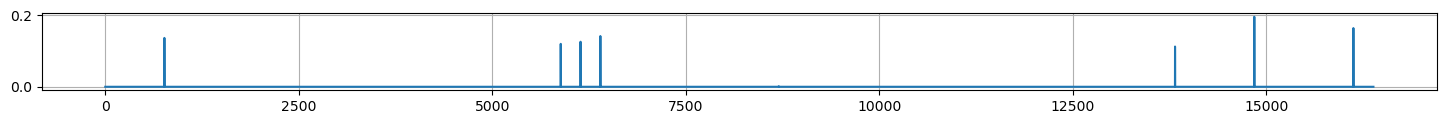

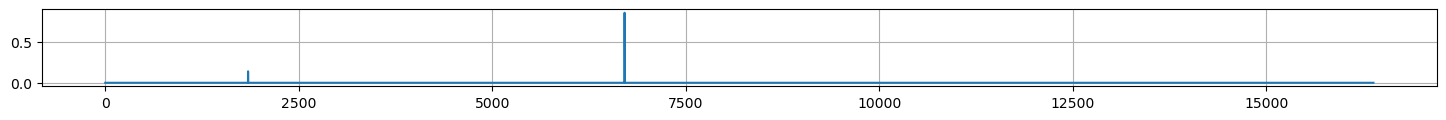

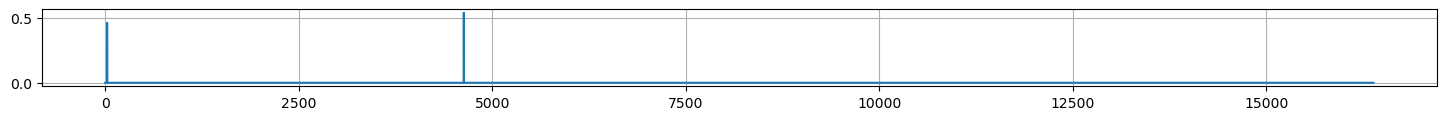

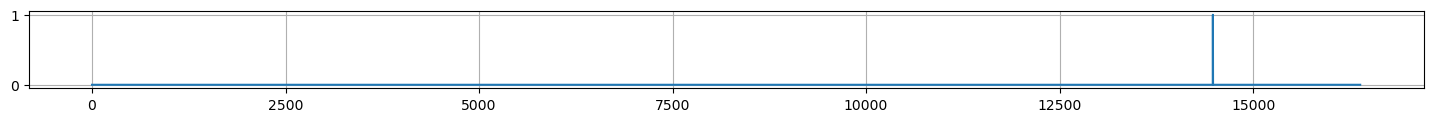

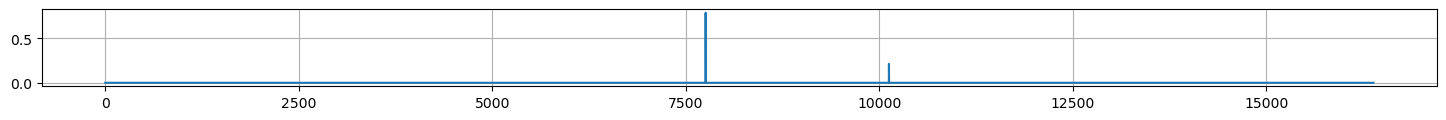

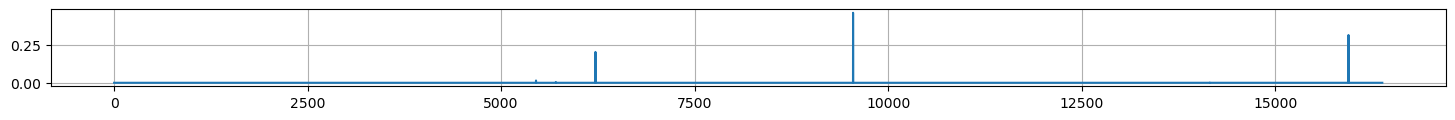

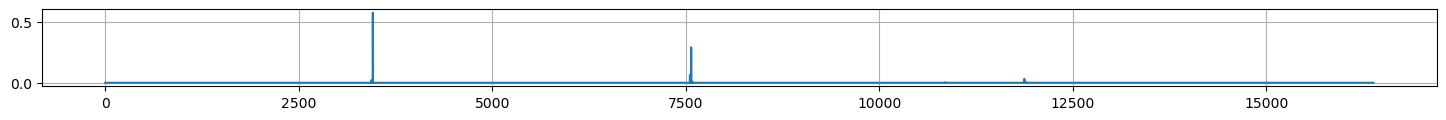

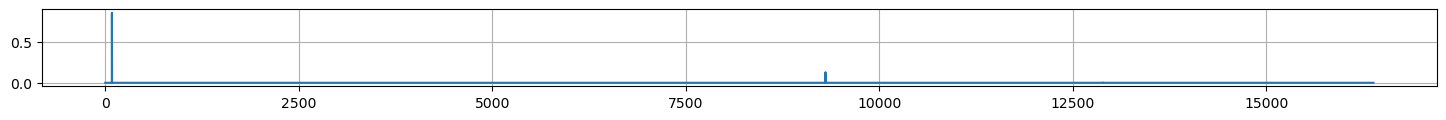

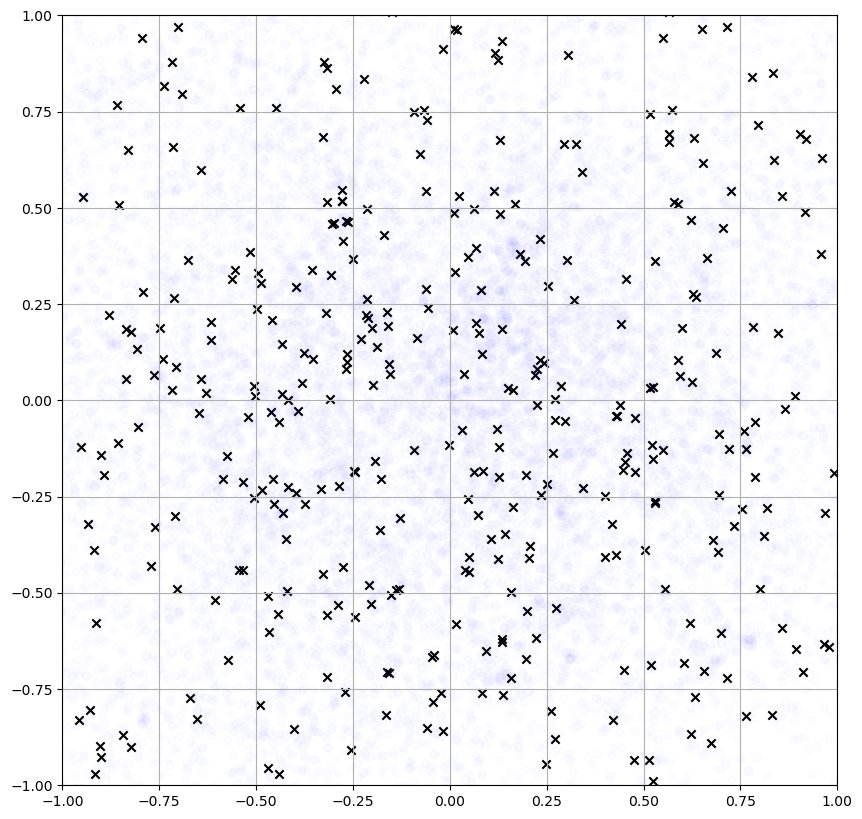

16001
lse_loss -107.73887634277344
commit_loss 0.1678999364376068
recon_loss 0.017630968242883682
16002
lse_loss -110.85758209228516
commit_loss 0.1770627200603485
recon_loss 0.017087947577238083
16003
lse_loss -111.02291107177734
commit_loss 0.18249112367630005
recon_loss 0.01816600374877453
16004
lse_loss -111.49556732177734
commit_loss 0.17515504360198975
recon_loss 0.01684066280722618
16005
lse_loss -109.76094818115234
commit_loss 0.17527878284454346
recon_loss 0.01754118502140045
16006
lse_loss -110.94751739501953
commit_loss 0.17624011635780334
recon_loss 0.01752547174692154
16007
lse_loss -111.66777801513672
commit_loss 0.17533454298973083
recon_loss 0.01637297123670578
16008
lse_loss -111.1875228881836
commit_loss 0.18657442927360535
recon_loss 0.016941271722316742
16009
lse_loss -109.52132415771484
commit_loss 0.18137870728969574
recon_loss 0.018169056624174118
16010
lse_loss -111.42704010009766
commit_loss 0.1776663064956665
recon_loss 0.01758817955851555
16011
lse_loss -112.

16086
lse_loss -110.37972259521484
commit_loss 0.1801542341709137
recon_loss 0.017697390168905258
16087
lse_loss -109.8041000366211
commit_loss 0.18050354719161987
recon_loss 0.018256425857543945
16088
lse_loss -110.3063735961914
commit_loss 0.17670884728431702
recon_loss 0.018799828365445137
16089
lse_loss -111.46870422363281
commit_loss 0.17919565737247467
recon_loss 0.017657343298196793
16090
lse_loss -112.42396545410156
commit_loss 0.17648673057556152
recon_loss 0.016445543617010117
16091
lse_loss -111.28561401367188
commit_loss 0.18062636256217957
recon_loss 0.019456248730421066
16092
lse_loss -110.725830078125
commit_loss 0.1678864061832428
recon_loss 0.016857095062732697
16093
lse_loss -111.04994201660156
commit_loss 0.17378579080104828
recon_loss 0.018510768190026283
16094
lse_loss -109.72600555419922
commit_loss 0.1686878800392151
recon_loss 0.019461248070001602
16095
lse_loss -108.78694915771484
commit_loss 0.17880785465240479
recon_loss 0.01850517839193344
16096
lse_loss -11

16171
lse_loss -112.66121673583984
commit_loss 0.17375633120536804
recon_loss 0.018220826983451843
16172
lse_loss -110.53337097167969
commit_loss 0.18169844150543213
recon_loss 0.01972660794854164
16173
lse_loss -112.27820587158203
commit_loss 0.17159247398376465
recon_loss 0.017500869929790497
16174
lse_loss -112.56026458740234
commit_loss 0.1719893515110016
recon_loss 0.01727832481265068
16175
lse_loss -110.82896423339844
commit_loss 0.1779891550540924
recon_loss 0.015557801350951195
16176
lse_loss -110.30938720703125
commit_loss 0.1737554669380188
recon_loss 0.018325507640838623
16177
lse_loss -112.20575714111328
commit_loss 0.1662444770336151
recon_loss 0.015864308923482895
16178
lse_loss -111.29936981201172
commit_loss 0.1753661334514618
recon_loss 0.018318165093660355
16179
lse_loss -112.54524993896484
commit_loss 0.1833571046590805
recon_loss 0.018665870651602745
16180
lse_loss -109.87141418457031
commit_loss 0.19166122376918793
recon_loss 0.021118273958563805
16181
lse_loss -11

16256
lse_loss -111.2662582397461
commit_loss 0.16838474571704865
recon_loss 0.01721826009452343
16257
lse_loss -112.87123107910156
commit_loss 0.17948973178863525
recon_loss 0.01643563061952591
16258
lse_loss -112.15593719482422
commit_loss 0.17419692873954773
recon_loss 0.01701410673558712
16259
lse_loss -110.2364501953125
commit_loss 0.17689324915409088
recon_loss 0.01813322678208351
16260
lse_loss -110.96643829345703
commit_loss 0.178777813911438
recon_loss 0.018399052321910858
16261
lse_loss -111.87403106689453
commit_loss 0.17975197732448578
recon_loss 0.01685664802789688
16262
lse_loss -111.46666717529297
commit_loss 0.18039795756340027
recon_loss 0.020335709676146507
16263
lse_loss -112.18987274169922
commit_loss 0.17343398928642273
recon_loss 0.01633571833372116
16264
lse_loss -112.11516571044922
commit_loss 0.18499106168746948
recon_loss 0.02030487172305584
16265
lse_loss -112.88788604736328
commit_loss 0.17263931035995483
recon_loss 0.017820268869400024
16266
lse_loss -110.2

16341
lse_loss -112.49909210205078
commit_loss 0.17389267683029175
recon_loss 0.01755402982234955
16342
lse_loss -113.33881378173828
commit_loss 0.17735479772090912
recon_loss 0.01795089989900589
16343
lse_loss -111.76669311523438
commit_loss 0.17140567302703857
recon_loss 0.01847967505455017
16344
lse_loss -111.76668548583984
commit_loss 0.17124754190444946
recon_loss 0.018540211021900177
16345
lse_loss -112.8141860961914
commit_loss 0.174078106880188
recon_loss 0.019438721239566803
16346
lse_loss -112.5566177368164
commit_loss 0.1808449774980545
recon_loss 0.017397413030266762
16347
lse_loss -110.66020965576172
commit_loss 0.18295258283615112
recon_loss 0.017096122726798058
16348
lse_loss -113.02290344238281
commit_loss 0.178932785987854
recon_loss 0.01979510486125946
16349
lse_loss -110.9942398071289
commit_loss 0.18587864935398102
recon_loss 0.01595018059015274
16350
lse_loss -112.36222076416016
commit_loss 0.18142955005168915
recon_loss 0.0186905600130558
16351
lse_loss -112.29229

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')